### 1. ライブラリ・関数の読み込み


### 1. ライブラリの読み込み


In [1]:
# install.packages(c("Matrix", "MatrixExtra", "recommenderlab", "cmfrec", "ggplot2", "reshape2", "viridis", "gridExtra"))
library(cmfrec)
library(dplyr)
library(lme4)
library(Matrix)
library(MatrixExtra)
library(recommenderlab)
library(cmfrec)
library(ggplot2)
library(reshape2)
library(viridis)
library(gridExtra)
source("cmf.R")



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: Matrix

'MatrixExtra' modifies important behaviors from 'Matrix'. See ?MatrixExtra-options.

Loading required package: arules


Attaching package: 'arules'


The following object is masked from 'package:dplyr':

    recode


The following objects are masked from 'package:base':

    abbreviate, write


Loading required package: proxy


Attaching package: 'proxy'


The following object is masked from 'package:Matrix':

    as.matrix


The following objects are masked from 'package:stats':

    as.dist, dist


The following object is masked from 'package:base':

    as.matrix


Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy


Attaching package: 'recommenderlab'


The following 

### 2. データの読み込み


In [2]:
brvehins <- load_bravehins(cas_dataset_path = "/Users/nanakato/projects/CASdatasets/data")
# brvehins <- load_bravehins(cas_dataset_path = "/Users/spectee/research/CASdatasets-master/data")
brvehins <- brvehins[grepl("Honda", brvehins$VehModel), ]
claim_types <- c("ClaimAmountRob", "ClaimAmountPartColl", "ClaimAmountTotColl", "ClaimAmountFire", "ClaimAmountOther")
brvehins[, "ClaimTotal"] <- rowSums(brvehins[, claim_types])
str(brvehins)

# write.csv(brvehins, file = "data/brvehins_org.csv", row.names = FALSE)


'data.frame':	81115 obs. of  24 variables:
 $ Gender             : Factor w/ 3 levels "Corporate","Female",..: 1 2 3 2 3 1 3 2 3 2 ...
 $ DrivAge            : Factor w/ 5 levels ">55","18-25",..: NA 4 4 3 1 NA 5 5 4 5 ...
 $ VehYear            : int  2006 2006 2007 2011 1995 2009 2004 2006 2010 2005 ...
 $ VehModel           : Factor w/ 4259 levels "Acura - Legend 3.2/3.5",..: 1754 1752 1728 1794 1799 1787 1775 1783 1780 1765 ...
 $ VehGroup           : Factor w/ 436 levels "Acura","Agrale - Marrua",..: 216 216 215 214 215 213 212 213 212 212 ...
 $ Area               : Factor w/ 40 levels "Acre","Alagoas",..: 40 13 19 30 30 24 4 24 30 20 ...
 $ State              : Factor w/ 27 levels "Acre","Alagoas",..: 25 25 16 25 25 13 4 13 25 25 ...
 $ StateAb            : Factor w/ 27 levels "AC","AL","AM",..: 26 26 18 26 26 11 3 11 26 26 ...
 $ ExposTotal         : num  1.51 0.5 0.5 0.1 0.5 ...
 $ ExposFireRob       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ PremTotal          : num  981.8 227.3 501.2 9

### 3. データの下処理


In [3]:
# category_to_analyze <- c("Gender", "DrivAge")
# category_to_analyze <- c("VehGroup", "VehYear")
category_to_analyze <- c("VehModel", "Area")

# exposure が 100 以上の区分のみを残す
premium_total <- get_total(brvehins, category_to_analyze, "PremTotal", 0)
exposure_total <- get_total(brvehins, category_to_analyze, "ExposTotal", 100)
claim_total <- get_total(brvehins, category_to_analyze, "ClaimTotal")

# exposure 合計が 10 以上の車種のみを残す
claim_total <- claim_total[rowSums(exposure_total, na.rm = TRUE) > 10, ]
premium_total <- premium_total[rowSums(exposure_total, na.rm = TRUE) > 10, ]
exposure_total <- exposure_total[rowSums(exposure_total, na.rm = TRUE) > 10, ]

# write.csv(exposure_total, "exposure_total.csv")
# write.csv(claim_total, "claim_total.csv")

# 純率にするか損害率にするかは要相談
# pure_premium <- premium_total / exposure_total
pure_premium <- claim_total / exposure_total
loss_ratio <- claim_total / premium_total

# write.csv(pure_premium, "pure_premium.csv")
# write.csv(loss_ratio, "loss_ratio.csv")


aggregate_col: PremTotal   group_cols: VehModelArea



[1] 125  40


aggregate_col: ExposTotal   group_cols: VehModelArea



[1] 125  40


aggregate_col: ClaimTotal   group_cols: VehModelArea



[1] 125  40


### 4. ハイパーパラメータの最適化


In [4]:
options(warn = -1)
best_params <- optimize_params(
    X = pure_premium,
    n_folds = 4,
    k_values = c(2, 5, 10, 15, 20, 30, 50),
    lambda_values = c(0.01, 0.1, 1, 10, 20, 30, 50, 100, 1000),
)
print(best_params)


[1] "k: 2 lambda: 0.01 CV RMSE: 954.083945750231"
[1] "k: 2 lambda: 0.1 CV RMSE: 1712.36948376564"
[1] "k: 2 lambda: 1 CV RMSE: 1365.75188464976"
[1] "k: 2 lambda: 10 CV RMSE: 812.547414073806"
[1] "k: 2 lambda: 20 CV RMSE: 703.706447911213"
[1] "k: 2 lambda: 30 CV RMSE: 633.950865459274"
[1] "k: 2 lambda: 50 CV RMSE: 550.938073383399"
[1] "k: 2 lambda: 100 CV RMSE: 496.349690058939"
[1] "k: 2 lambda: 1000 CV RMSE: 473.725188764418"
[1] "k: 5 lambda: 0.01 CV RMSE: 2510.09290409067"
[1] "k: 5 lambda: 0.1 CV RMSE: 1340.84816071535"
[1] "k: 5 lambda: 1 CV RMSE: 1303.55950855333"
[1] "k: 5 lambda: 10 CV RMSE: 546.297421026159"
[1] "k: 5 lambda: 20 CV RMSE: 531.16460942208"
[1] "k: 5 lambda: 30 CV RMSE: 532.682637542328"
[1] "k: 5 lambda: 50 CV RMSE: 501.646243966058"
[1] "k: 5 lambda: 100 CV RMSE: 499.93115272379"
[1] "k: 5 lambda: 1000 CV RMSE: 471.686690484188"
[1] "k: 10 lambda: 0.01 CV RMSE: 1940.23295513988"
[1] "k: 10 lambda: 0.1 CV RMSE: 1577.28325928294"
[1] "k: 10 lambda: 1 CV RMS

### 5. 予測精度の検証


In [5]:
split <- train_test_split(pure_premium)
# # export split$X_train to csv
# write.csv(split$X_train, "data/split$X_train.csv")
# # export split$X_test to csv
# write.csv(split$X_test, "data/split$X_test.csv")

# cmf_args <- list(X = split$X_train, k = best_params$k, lambda = best_params$lambda, niter = 30, nonneg = TRUE, verbose = FALSE)
# cmf_args <- list(X = split$X_train, k = best_params$k, lambda = best_params$lambda, niter = 30, nonneg = FALSE, verbose = FALSE)
cmf_args <- list(X = split$X_train, k = best_params$k, lambda = best_params$lambda, niter = 30, nonneg = TRUE, verbose = FALSE, center = FALSE)

model <- do.call(CMF, cmf_args)

pred <- get_prediction(model, split$X_test)
calc_rmse(pred, split$X_test)


RMSE : 559.3684


[1] 559.3684

### 6. 予測結果の可視化


#### (1) テストデータにおける再現性の確認


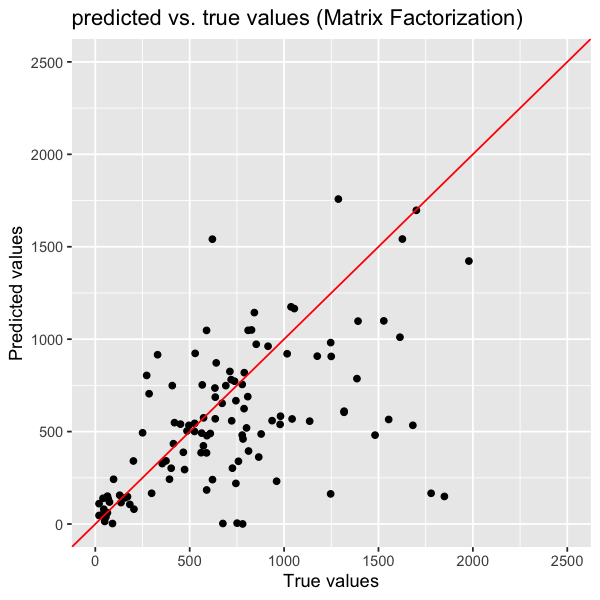

In [6]:
# テストデータにおける予測値と実測値の散布図
options(repr.plot.width = 5, repr.plot.height = 5)
visualize_scatter_plot(as.vector(split$X_test), as.vector(pred), "Matrix Factorization")


#### (2) 欠測値の推定


RMSE : 3.3336


[1] 3.333628

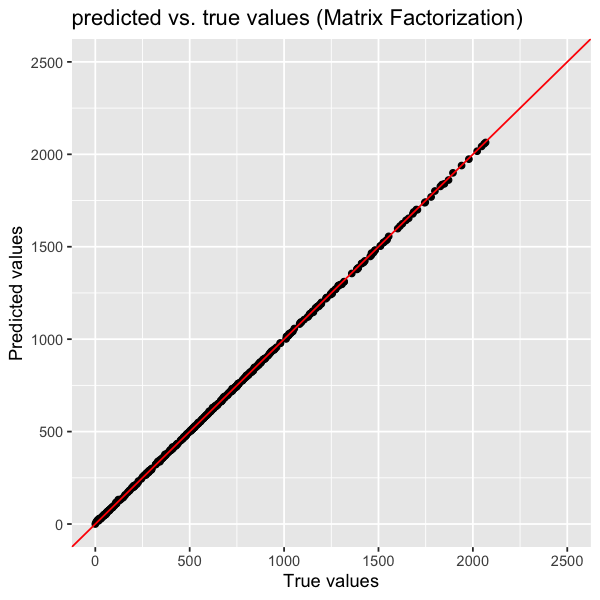

In [7]:
options(repr.plot.width = 5, repr.plot.height = 5)

# 全データによる予測値作成
all_data <- pure_premium
cmf_args <- list(X = all_data, k = best_params$k, lambda = best_params$lambda, niter = 30, nonneg = TRUE, verbose = FALSE, center = FALSE)
model <- do.call(CMF, cmf_args)

pred <- get_prediction(model, all_data)
calc_rmse(pred, all_data) # training RMSE with all data

visualize_scatter_plot(actual = as.vector(all_data), pred = as.vector(pred), "Matrix Factorization")


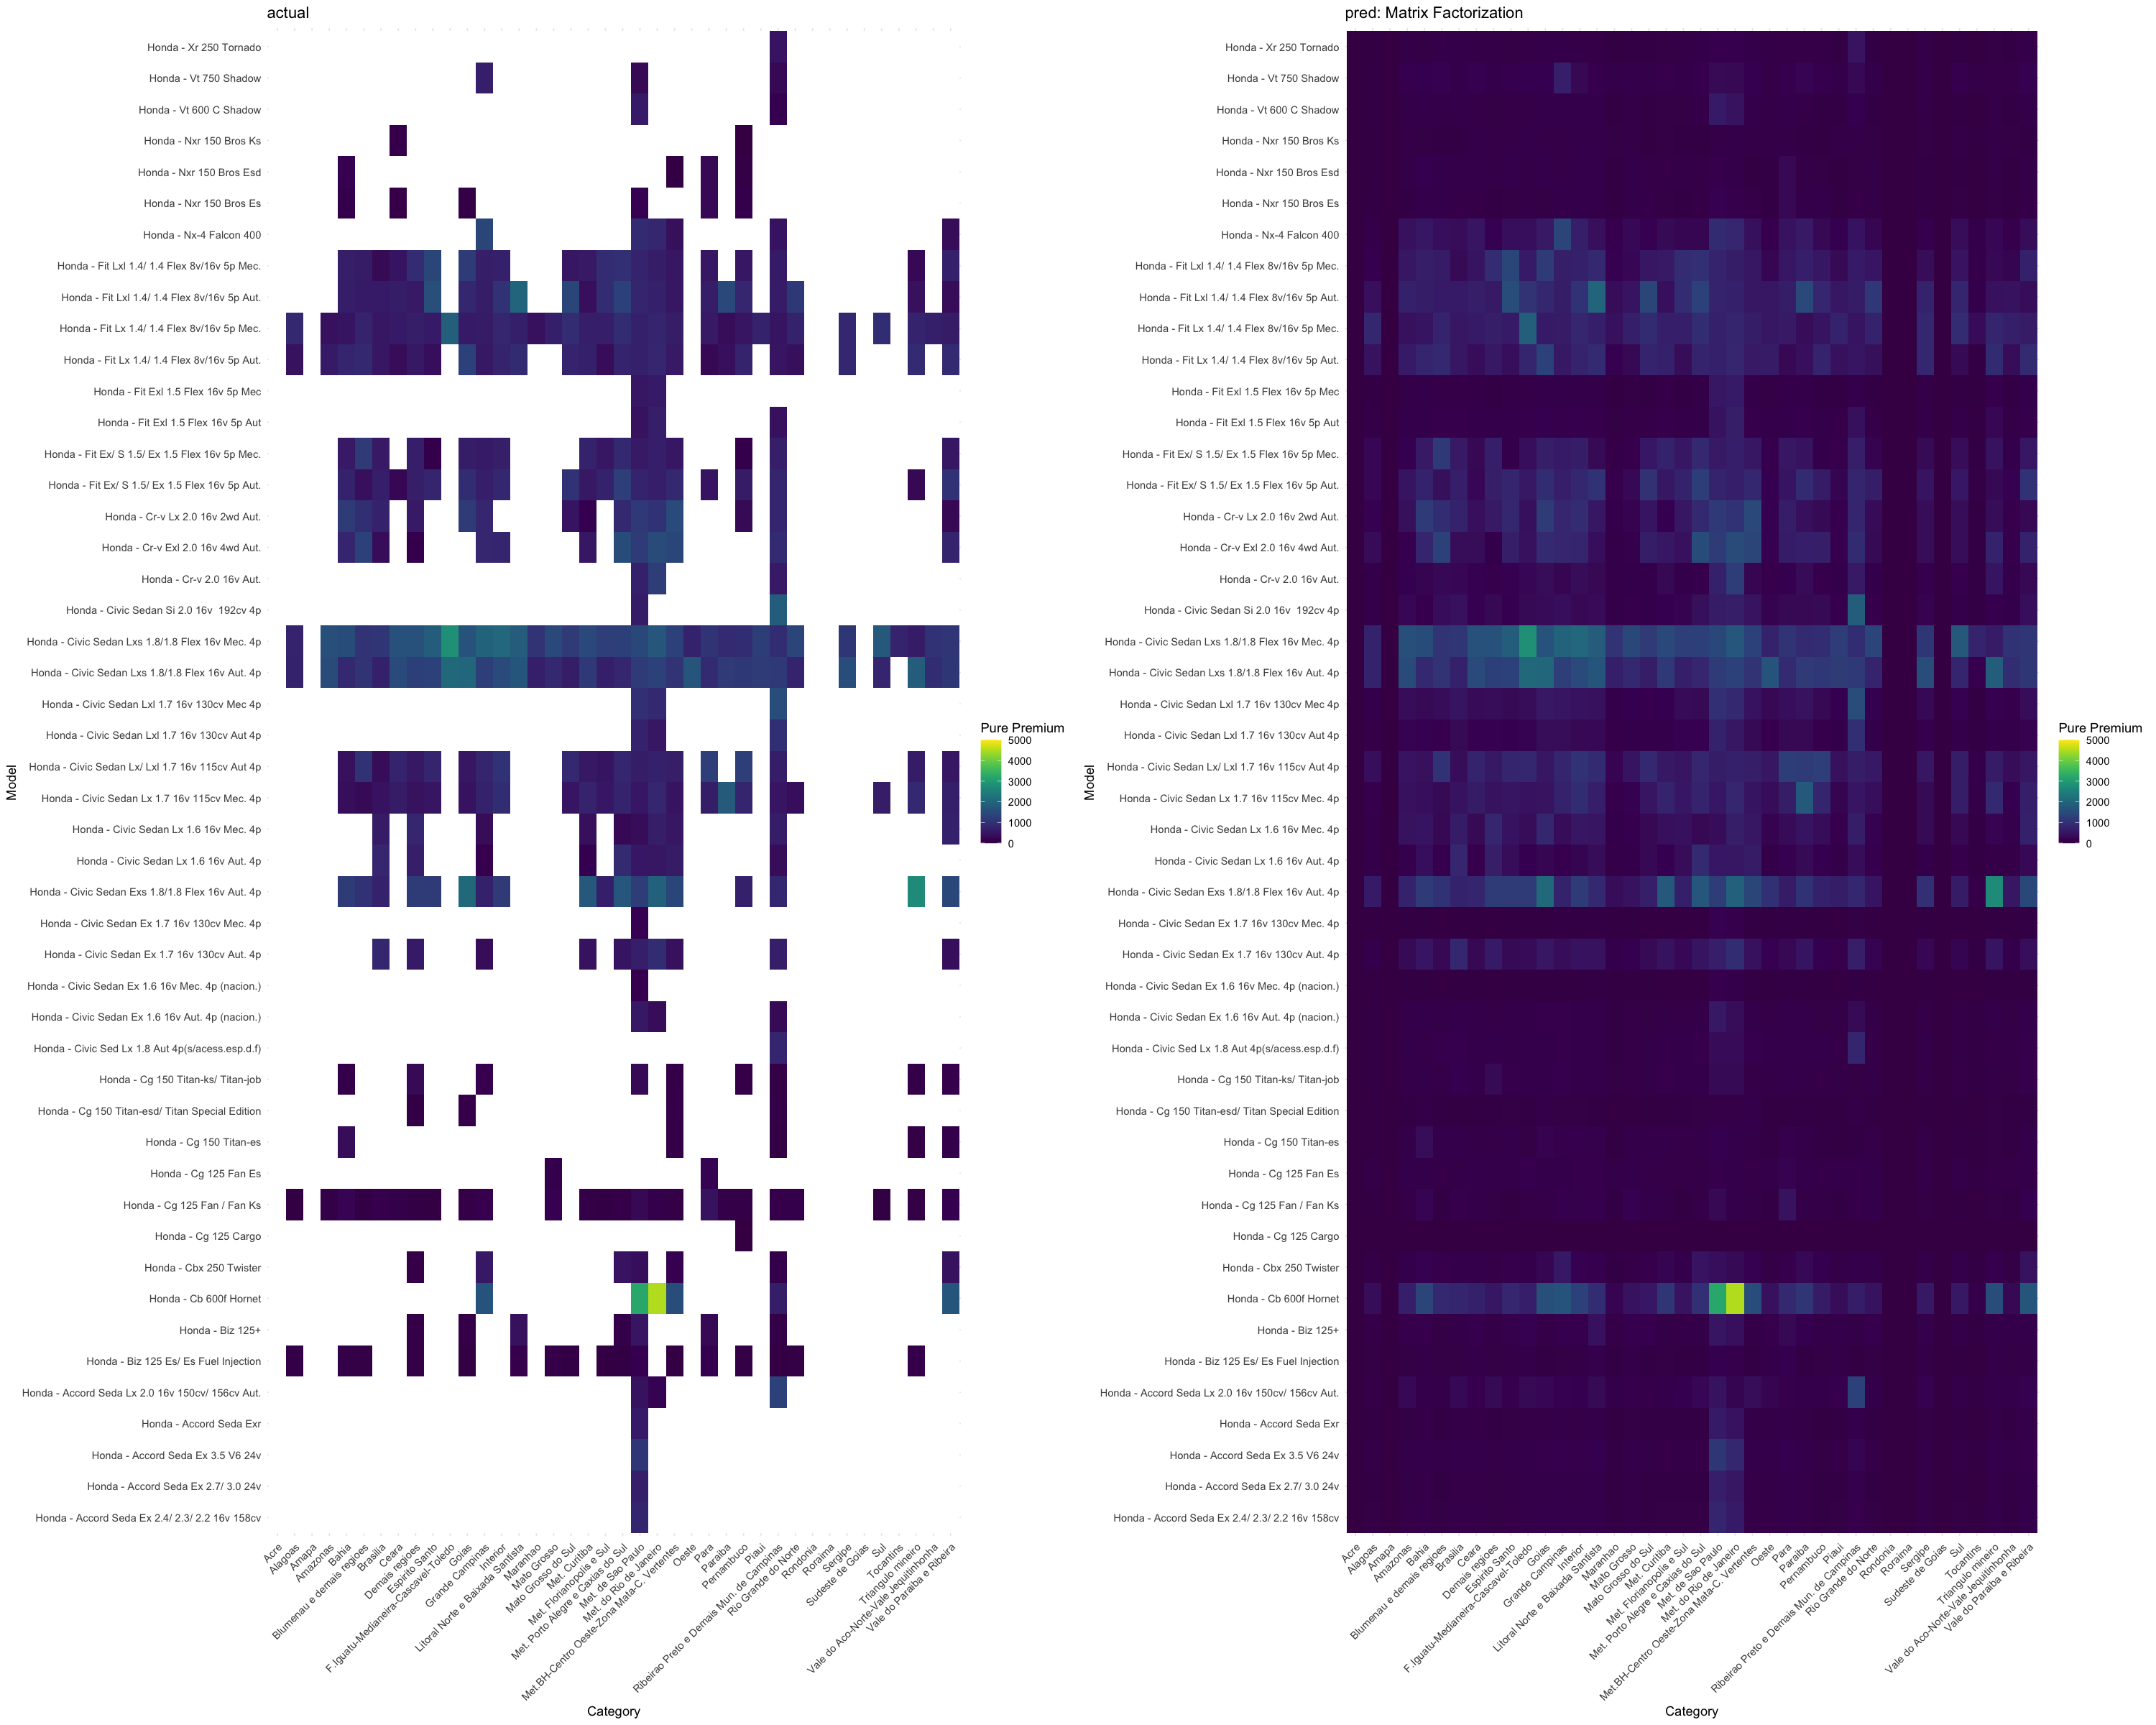

In [8]:
options(repr.plot.width = 25, repr.plot.height = 20)

# 全区分に対するヒートマップ（実績）
p1 <- visualize_heatmap(all_data, "actual")

# 全区分に対するヒートマップ（欠測を含む推定値）
actual <- all_data
actual[is.na(actual)] <- 0
estimated <- get_prediction(model, actual)
p2 <- visualize_heatmap(estimated, "pred: Matrix Factorization")

grid.arrange(p1, p2, ncol = 2)


### 7. 交互作用なしの GLM との比較


In [9]:
exposure <- wide_to_long_format(exposure_total, c("VehModel", "Area", "exposure"), na_omit = FALSE)
all_data <- wide_to_long_format(pure_premium, c("VehModel", "Area", "pure_premium"), na_omit = FALSE)
all_data <- merge(all_data, exposure, by = c("VehModel", "Area"))

# glm_args <- list(formula = pure_premium * exposure ~ VehModel + Area + offset(log(exposure)), family = poisson(link = "log"), data = all_data)
glm_args <- list(formula = pure_premium * exposure ~ VehModel + Area + offset(log(exposure)), family = poisson(link = "log"), data = na.omit(all_data))
glm_model <- do.call(glm, glm_args)
# summary(glm_model)


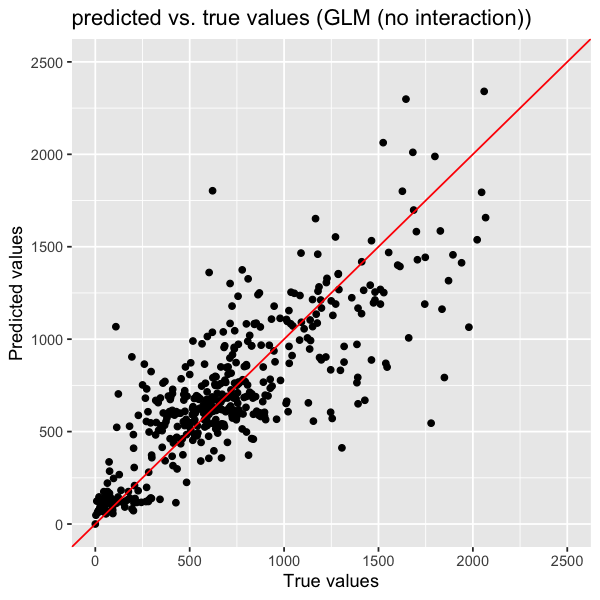

In [10]:
options(repr.plot.width = 5, repr.plot.height = 5)

pred <- predict(glm_model, newdata = na.omit(all_data), type = "response") / na.omit(all_data)$exposure
visualize_scatter_plot(
    actual = as.vector(na.omit(all_data)$pure_premium),
    pred = as.vector(pred),
    model_name = "GLM (no interaction)"
)


aggregate_col: pred   group_cols: VehModelArea



[1] 48 40


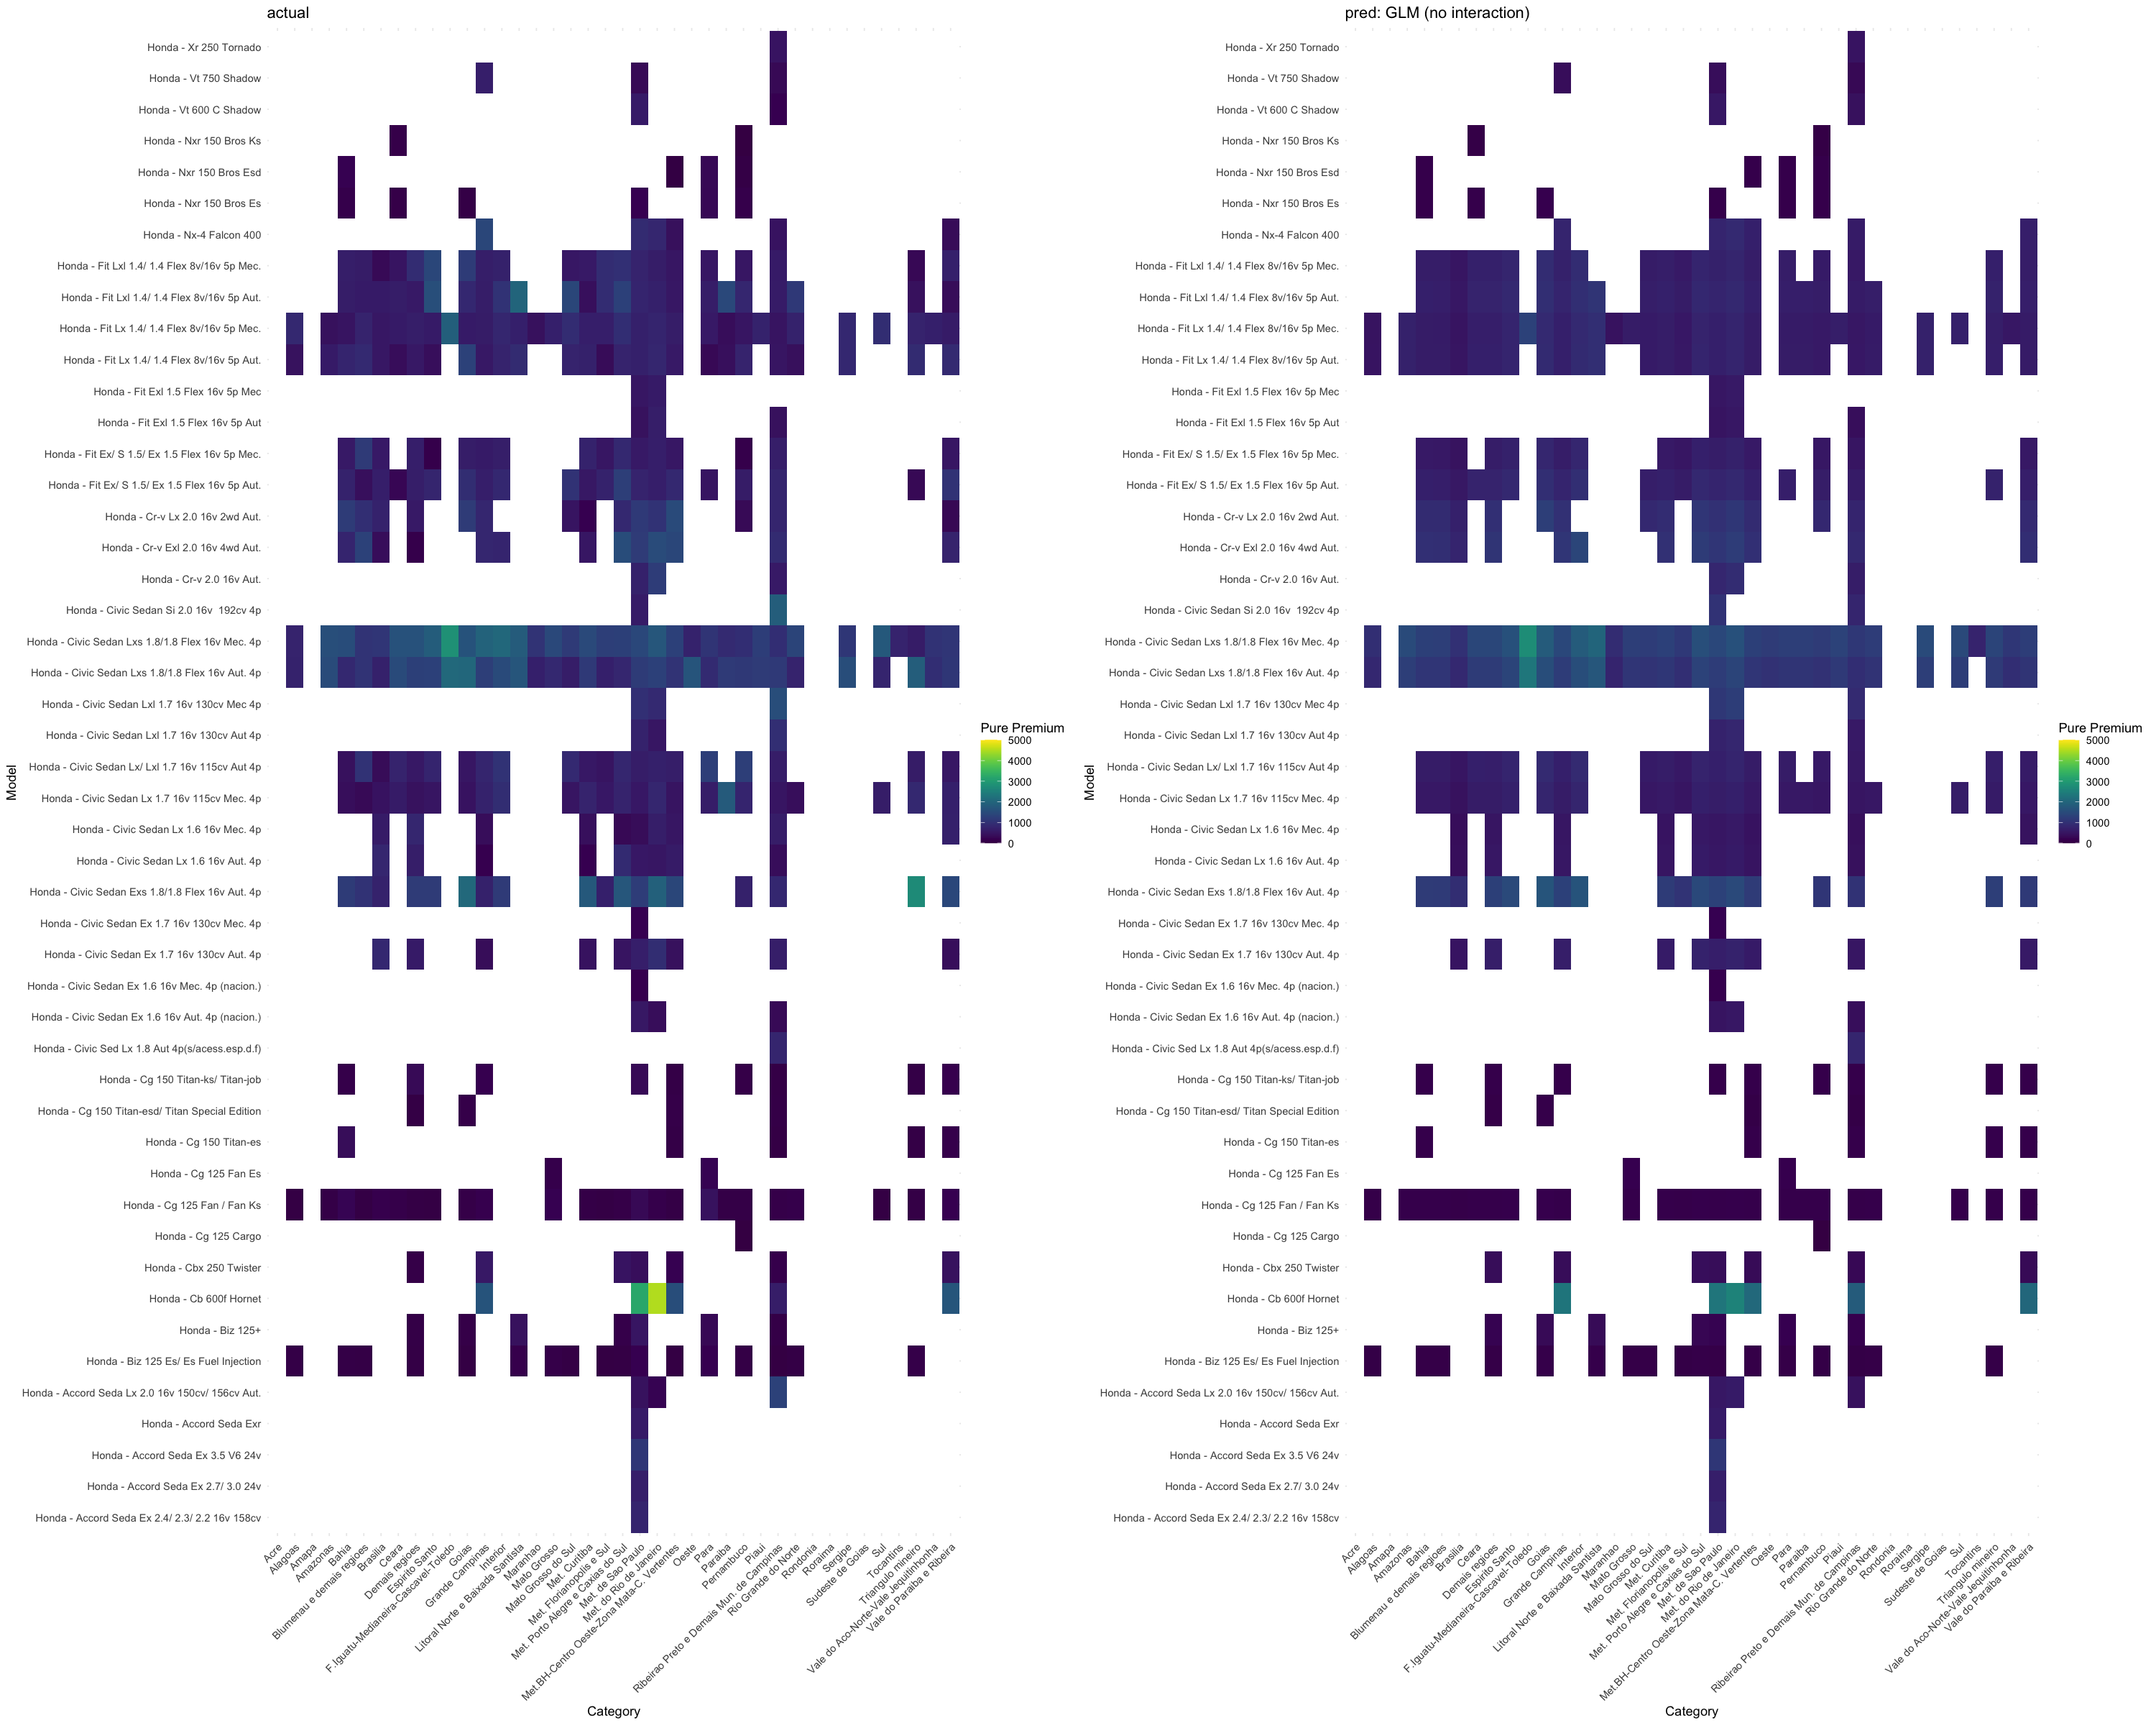

In [11]:
options(repr.plot.width = 25, repr.plot.height = 20) # 欠測推定なし

row_names <- row.names(na.omit(all_data))
all_data[, "pred"] <- NA
all_data[row_names, "pred"] <- pred
all_data_pred_wide_format <- get_total(all_data, category_to_analyze, "pred", 0)

# 全区分に対するヒートマップ（実績）
p1 <- visualize_heatmap(pure_premium, "actual")

# 全区分に対するヒートマップ（推定値）：もともと観察がないカテゴリーの推定は行えない
actual <- pure_premium
actual[is.na(actual)] <- 0
estimated <- all_data_pred_wide_format
p2 <- visualize_heatmap(estimated, "pred: GLM (no interaction)")

grid.arrange(p1, p2, ncol = 2)


aggregate_col: pred   group_cols: VehModelArea



[1] 48 40


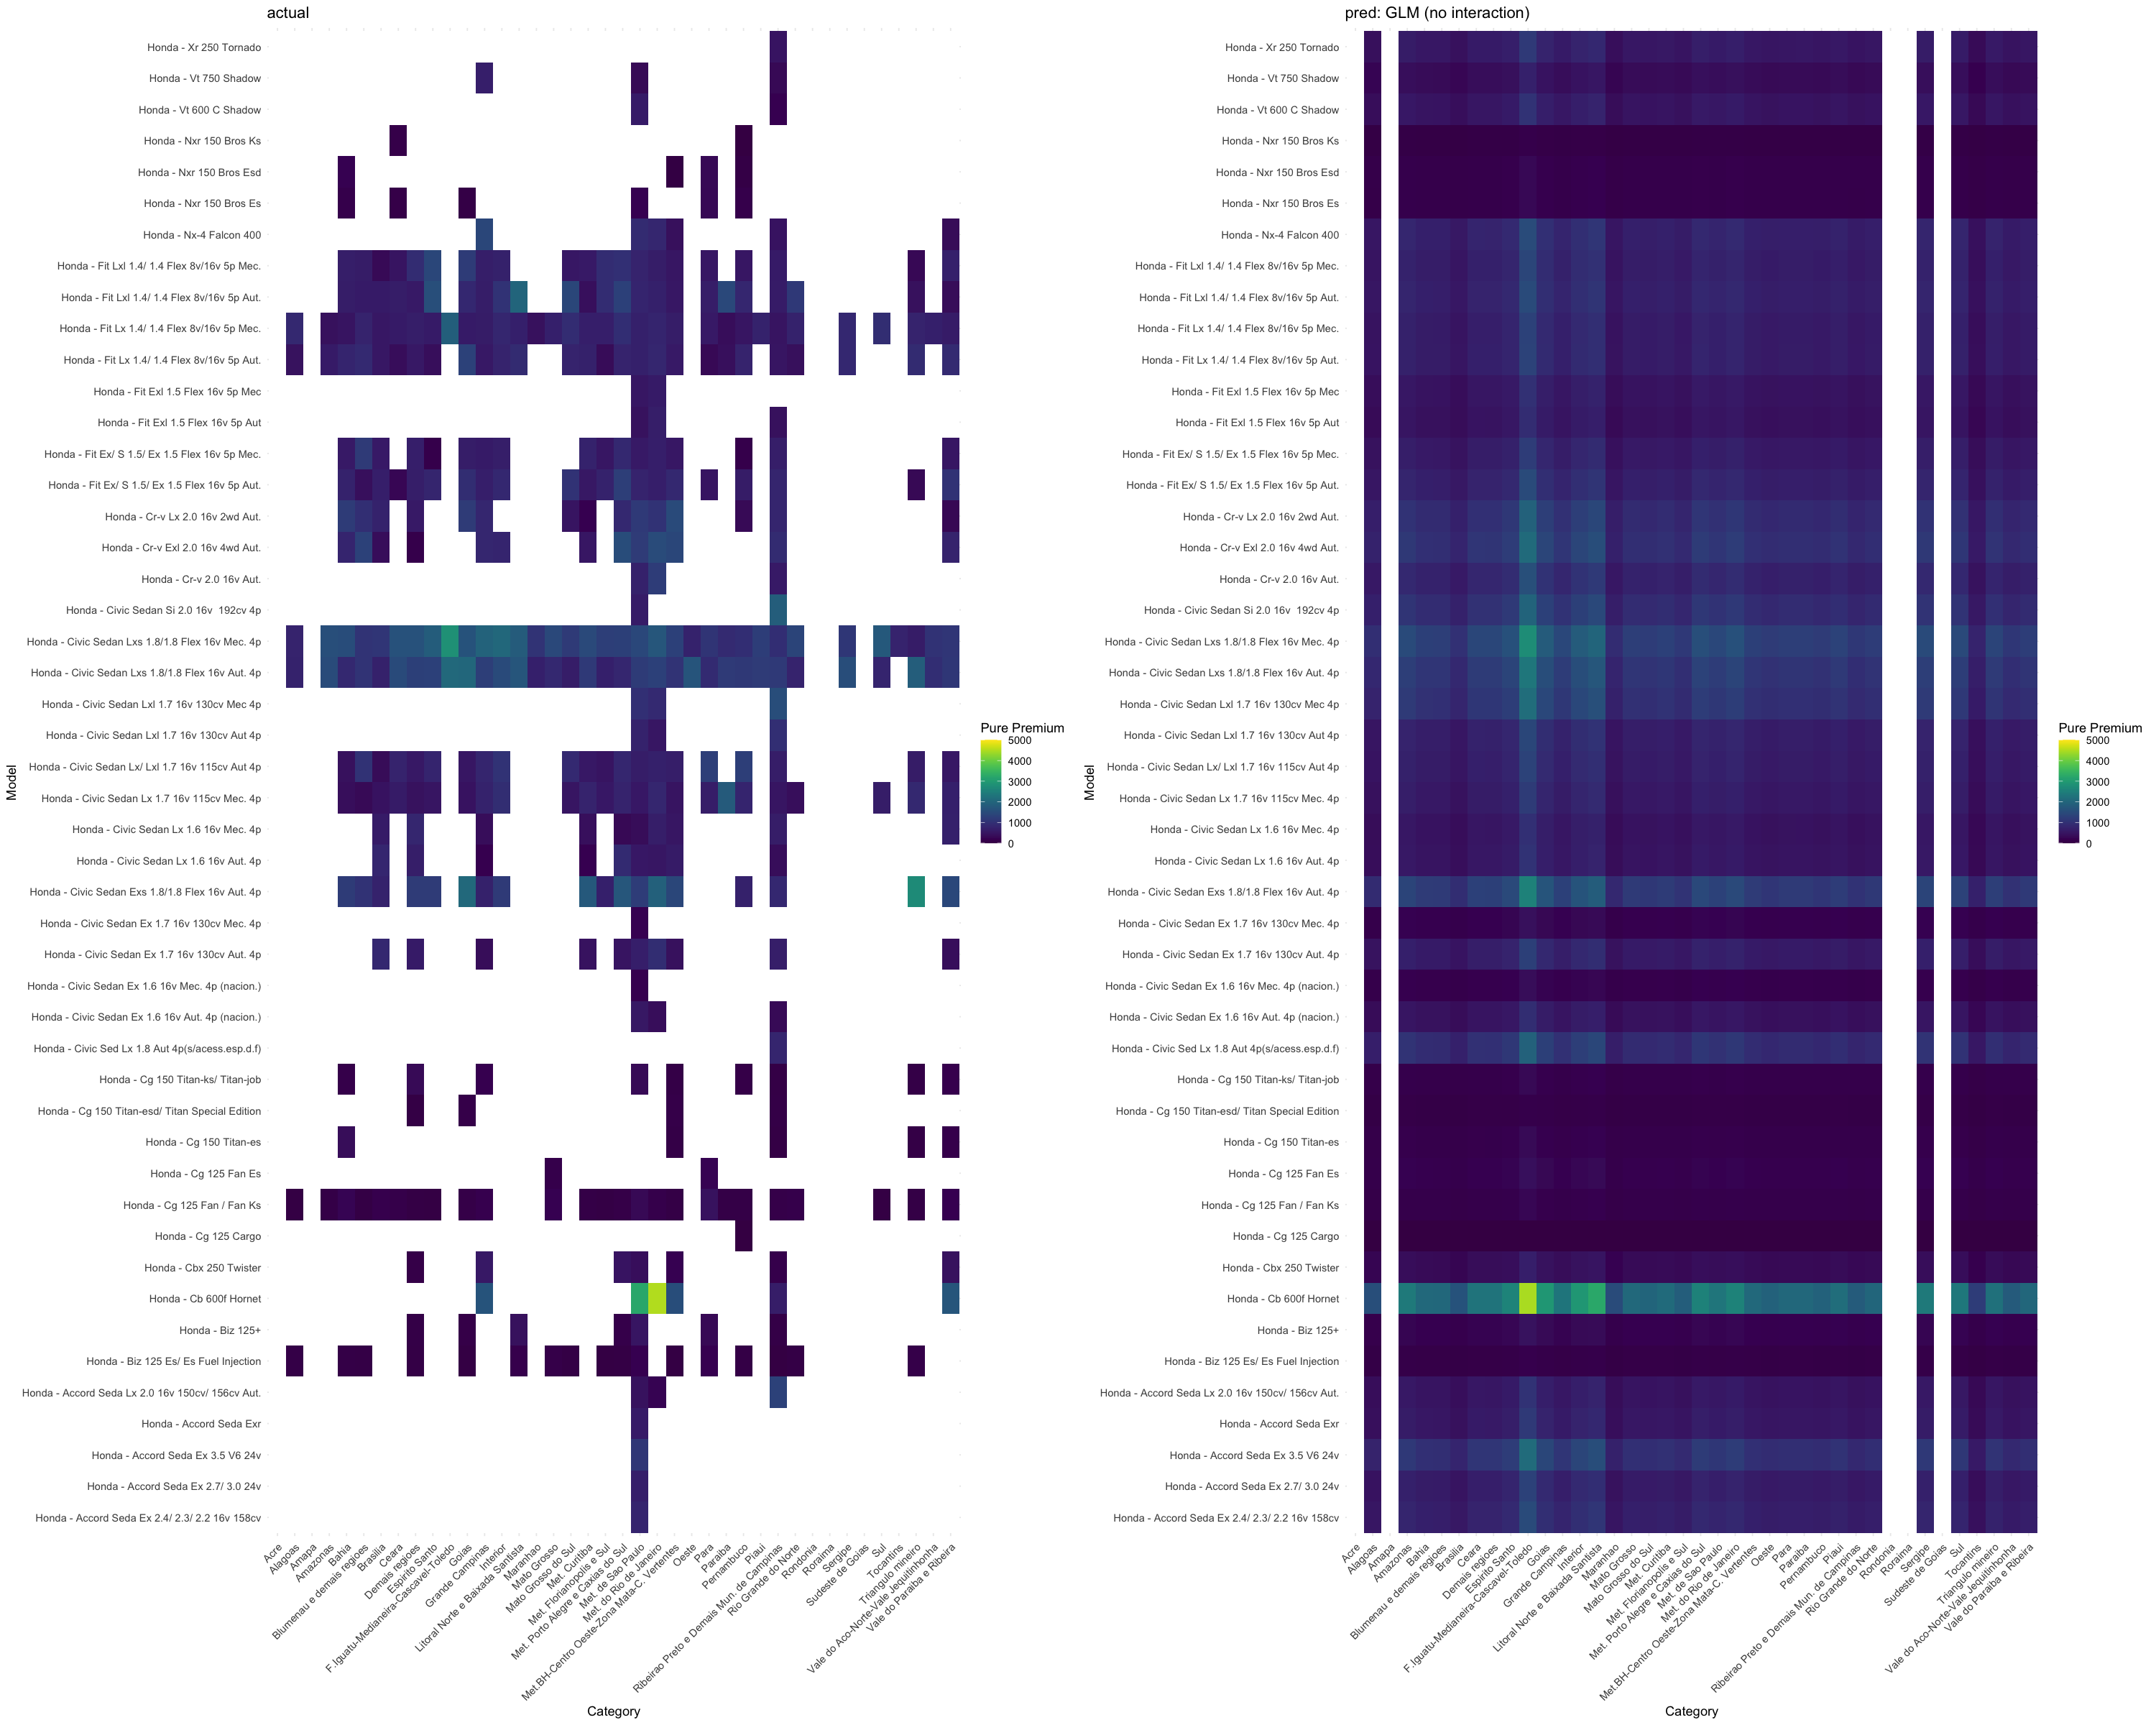

In [12]:
options(repr.plot.width = 25, repr.plot.height = 20) # 欠測推定あり

exposure <- wide_to_long_format(exposure_total, c("VehModel", "Area", "exposure"), na_omit = FALSE)
all_data <- wide_to_long_format(pure_premium, c("VehModel", "Area", "pure_premium"), na_omit = FALSE)
all_data <- merge(all_data, exposure, by = c("VehModel", "Area"))

valid_veh_types <- unique(glm_model$data$VehModel)
valid_areas <- unique(glm_model$data$Area)

data_with_all_combinations <- expand.grid(VehModel = valid_veh_types, Area = valid_areas)
data_with_all_combinations <- merge(data_with_all_combinations, all_data, by = c("VehModel", "Area"), all.x = TRUE)
data_with_all_combinations[is.na(data_with_all_combinations$exposure), "exposure"] <- 1 # exposure が NA の区分は 1 として予測

pred <- predict(glm_model, newdata = data_with_all_combinations, type = "response") / data_with_all_combinations$exposure
data_with_all_combinations$pred <- pred

all_data <- merge(all_data, data_with_all_combinations, by = c("VehModel", "Area"), all.x = TRUE)
all_data_pred_wide_format <- get_total(all_data, category_to_analyze, "pred", 0)

# 全区分に対するヒートマップ（実績）
p1 <- visualize_heatmap(pure_premium, "actual")

# 全区分に対するヒートマップ（推定値）：もともと観察がないカテゴリーの推定は行えない
actual <- pure_premium
actual[is.na(actual)] <- 0
estimated <- all_data_pred_wide_format
p2 <- visualize_heatmap(estimated, "pred: GLM (no interaction)")

grid.arrange(p1, p2, ncol = 2)


### 8. 交互作用を変量効果に入れた GLMM との比較


In [13]:
exposure <- wide_to_long_format(exposure_total, c("VehModel", "Area", "exposure"), na_omit = FALSE)
all_data <- wide_to_long_format(pure_premium, c("VehModel", "Area", "pure_premium"), na_omit = FALSE)
all_data[, "interaction"] <- interaction(as.character(all_data$VehModel), as.character(all_data$Area))
all_data <- merge(all_data, exposure, by = c("VehModel", "Area"))
# write.csv(all_data, "all_data.csv")

glmm_args <- list(formula = pure_premium * exposure ~ VehModel + Area + (1 | interaction), family = poisson(link = "log"), data = all_data, offset = log(all_data$exposure))
glmm_model <- do.call(glmer, glmm_args)


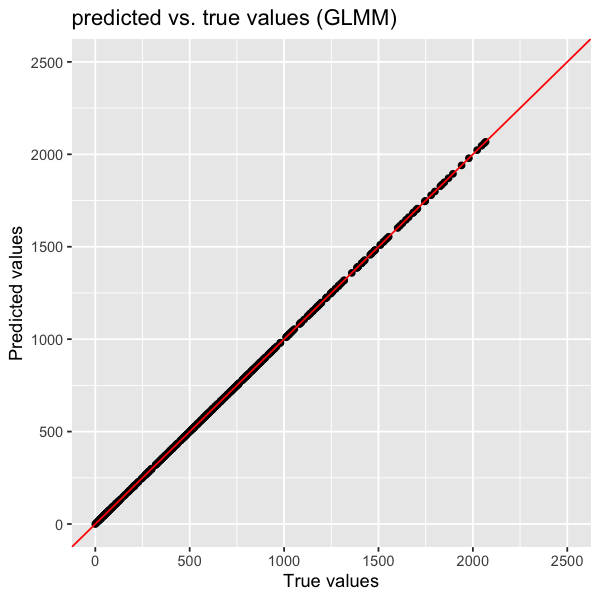

In [14]:
options(repr.plot.width = 5, repr.plot.height = 5)

# show scatter plot for training data for sanity check
pred <- predict(glmm_model, newdata = na.omit(all_data), type = "response")
visualize_scatter_plot(
  actual = as.vector(na.omit(all_data)$pure_premium),
  pred = as.vector(pred),
  model_name = "GLMM"
)


In [15]:
str(all_data)


'data.frame':	1920 obs. of  5 variables:
 $ VehModel    : Factor w/ 48 levels "Honda - Accord Seda Ex 2.4/ 2.3/ 2.2 16v 158cv",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Area        : Factor w/ 40 levels "Acre","Alagoas",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ pure_premium: num  NA NA NA NA NA NA NA NA NA NA ...
 $ interaction : Factor w/ 1920 levels "Honda - Accord Seda Ex 2.4/ 2.3/ 2.2 16v 158cv.Acre",..: 1 49 97 145 193 241 289 337 385 433 ...
 $ exposure    : num  NA NA NA NA NA NA NA NA NA NA ...


aggregate_col: pred   group_cols: VehModelArea



[1] 48 40


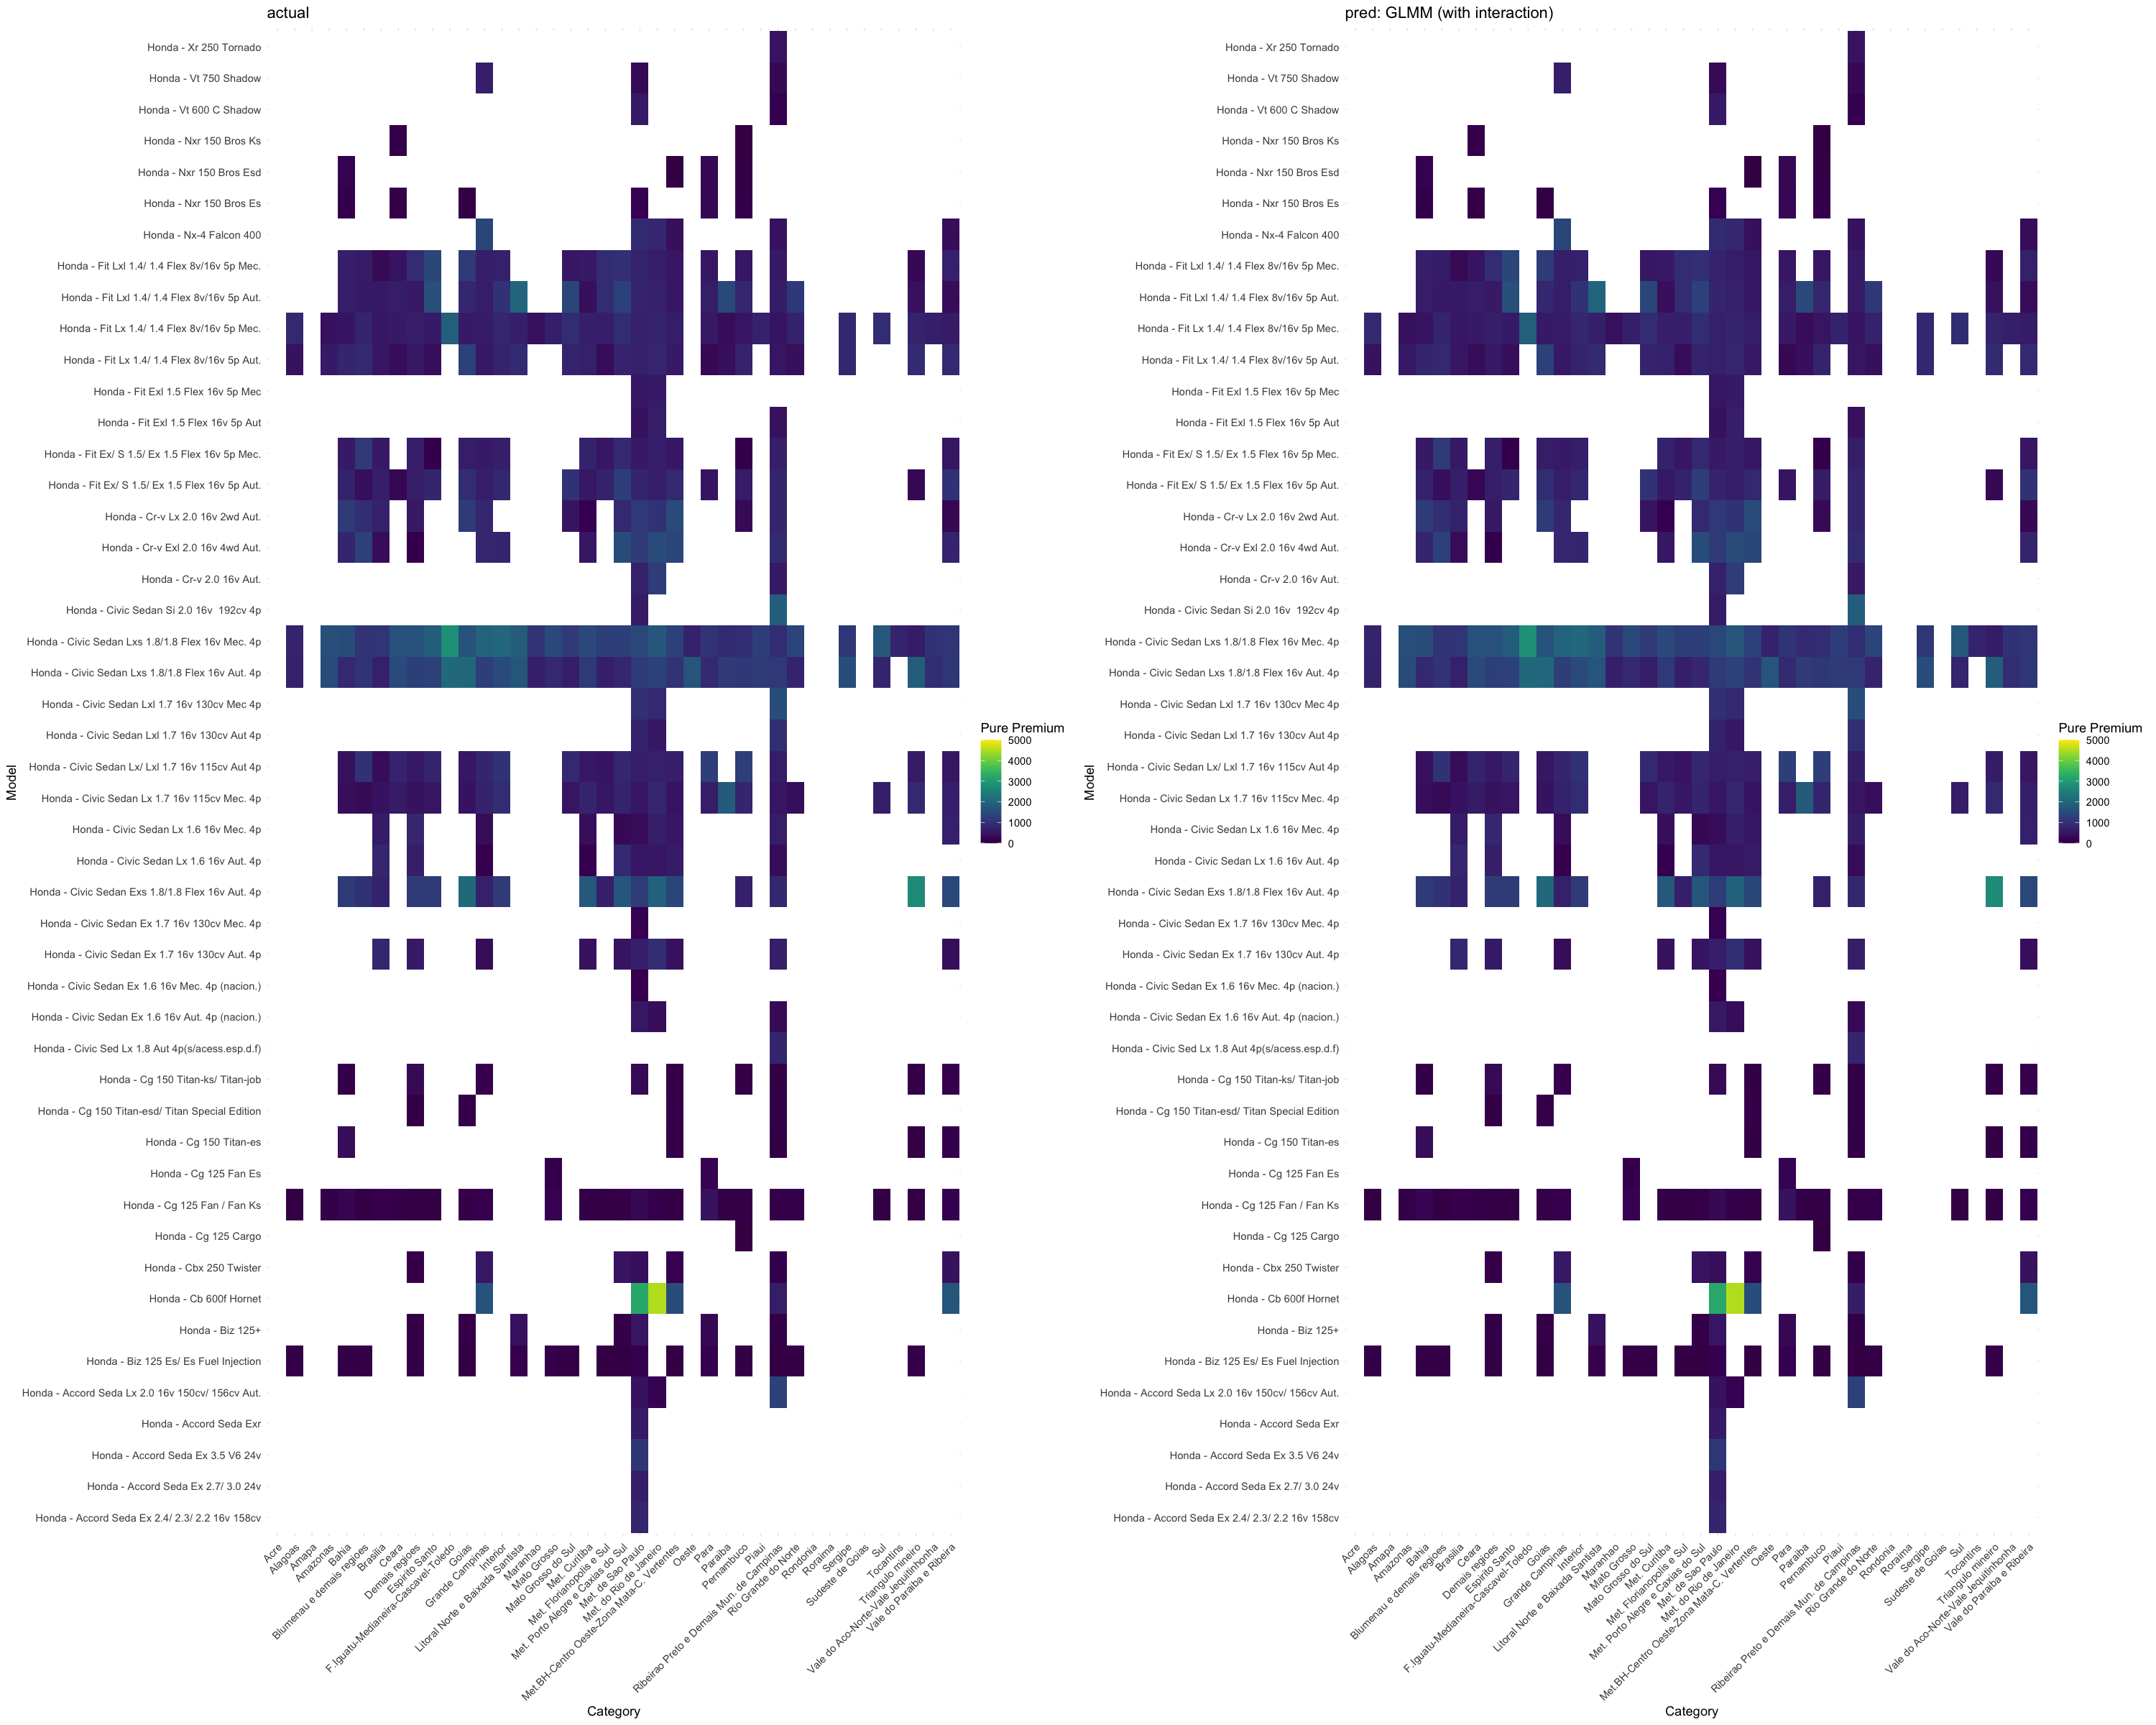

In [18]:
options(repr.plot.width = 25, repr.plot.height = 20) # 欠測推定なし

row_names <- row.names(na.omit(all_data))
all_data[, "pred"] <- NA
all_data[row_names, "pred"] <- pred
all_data_pred_wide_format <- get_total(all_data, category_to_analyze, "pred", 0)

# 全区分に対するヒートマップ（実績）
p1 <- visualize_heatmap(pure_premium, "actual")

# 全区分に対するヒートマップ（推定値）：もともと観察がないカテゴリーの推定は行えない
actual <- pure_premium
actual[is.na(actual)] <- 0
estimated <- all_data_pred_wide_format
p2 <- visualize_heatmap(estimated, "pred: GLMM (with interaction)")

grid.arrange(p1, p2, ncol = 2)
